### 1.
 We want to explore the general trend of the conversation data. For this purpose, create a dataframe for each speaker by gathering all his utterances in a single file.
Then write a script that determines the vocabulary set, vocabulary size, total number of tokens, total number of repetitions of words in the same post, total number of confirmation words (e.g., yes, OK, sure), total number of negation tokens, associated to each speaker. Summarize the result in a table, and then draw a subgraph that shows on the same plot the evolution of number of repetitions, number of negation, number of confirmation-like tokens, with respect to the number of tokens employed for each speaker (You may create some subdivision from the total number of tokens to ensure enough datum are used to represent the graphical illustration). Calculate the overall personality for each speaker by averaging over all instances of the original dataset, and comment on possible similarities and differences between speakers and whether some attributes are more associated with some personality patterns.

In [47]:
# Download dataset from GitHub repository
import pandas as pd
url = "https://raw.githubusercontent.com/preke/PELD/main/data/Dyadic_PELD.tsv"
df = pd.read_csv(url, sep='\t')
df.to_csv("Dyadic_PELD.tsv", sep='\t', index=False)

In [48]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6510 entries, 0 to 6509
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Speaker_1    6510 non-null   object
 1   Speaker_2    6510 non-null   object
 2   Personality  6510 non-null   object
 3   Utterance_1  6510 non-null   object
 4   Utterance_2  6510 non-null   object
 5   Utterance_3  6510 non-null   object
 6   Emotion_1    6510 non-null   object
 7   Emotion_2    6510 non-null   object
 8   Emotion_3    6510 non-null   object
 9   Sentiment_1  6510 non-null   object
 10  Sentiment_2  6510 non-null   object
 11  Sentiment_3  6510 non-null   object
dtypes: object(12)
memory usage: 610.4+ KB
None


In [49]:
# save each speaker with their utterances in separate files
distinct_speakers1 = df['Speaker_1'].unique()
print('speaker 1: ', distinct_speakers1)
for s in distinct_speakers1:
    lines = (pd.concat([df.loc[df['Speaker_1']==s, 'Utterance_1'],                       
                        df.loc[df['Speaker_2']==s, 'Utterance_2']])
               .dropna()
               .rename('utterance'))
    lines.to_csv(f'{s}_utterances.csv', index=False)

speaker 1:  ['Chandler' 'Joey' 'Rachel' 'Monica' 'Phoebe' 'Ross']


In [50]:
# load each speaker's utterances with a dataframe from the saved files
df_Chandler = pd.read_csv('Chandler_utterances.csv')
df_Monica = pd.read_csv('Monica_utterances.csv')
df_Ross = pd.read_csv('Ross_utterances.csv')
df_Rachel = pd.read_csv('Rachel_utterances.csv')
df_Joey = pd.read_csv('Joey_utterances.csv')
df_Phoebe = pd.read_csv('Phoebe_utterances.csv')

In [51]:
# generate confirmation words set from seed words
from nltk.corpus import wordnet as wn
seed = {'yes', 'yeah', 'yep', 'sure', 'okay', 'ok', 'indeed', 'exactly', 'right',
        'correct', 'absolutely', 'definitely', 'certainly', 'affirmative'}
def generate_synonyms(seed):
    res = set(seed)
    for word in list(seed):
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                res.add(lemma.name().replace('_', ' '))
    return res

confirmation_words = generate_synonyms(seed)
print(sorted(confirmation_words))
confirmation_words = list(confirmation_words)

print(len(confirmation_words), ' confirmation words generated.')
print(len(seed), ' seed words used.')

['O.K.', 'OK', 'Oklahoma', 'Sooner State', 'absolutely', 'adjust', 'affirmative', 'affirmatory', 'all right', 'alright', 'approbative', 'approbatory', 'approve', 'approving', 'aright', 'by all odds', 'castigate', 'certain', 'certainly', 'chasten', 'chastise', 'compensate', 'correct', 'correctly', 'counterbalance', 'dead', 'decent', 'decently', 'decidedly', 'decline', 'definitely', 'discipline', 'emphatically', 'even off', 'even out', 'even up', 'exactly', 'fine', 'flop', 'for certain', 'for sure', 'good', 'hunky-dory', 'in good order', 'in spades', 'incisively', 'indeed', 'indisputable', 'just', 'justly', 'make up', 'mightily', 'mighty', 'o.k.', 'objurgate', 'ok', 'okay', 'okeh', 'okey', 'on the button', 'on the dot', 'on the nose', 'optimistic', 'perfectly', 'plausive', 'powerful', 'precisely', 'proper', 'properly', 'rectify', 'redress', 'right', 'right field', 'right hand', 'right on', 'right wing', 'right-hand', 'rightfield', 'rightfulness', 'ripe', 'sanction', 'set', 'slump', 'so',

In [52]:
#  negation word list
negation_words = {
    "no", "not", "never", "none", "nothing", "nobody", "nowhere",
    "neither", "nor", "barely", "hardly", "scarcely", "seldom", "little",
    "few", "without", "lack", "lacking", "cannot"
}
negation_words = generate_synonyms(negation_words)
negation_pattern = r"\b\w+n't\b"

print(len(negation_words), ' negation words loaded.')

63  negation words loaded.


In [53]:
# get the vocabulary set and size associated to each speaker.
from nltk.tokenize import RegexpTokenizer
from tabulate import tabulate
import re

tokenizer = RegexpTokenizer(r"[A-Za-z']+")

def build_speaker_vocab_info(df, stride):
    utterancesArr = df['utterance'].str.lower().tolist()
    
    token_count = 0
    negation_tokens_count = 0
    confirmation_count = 0
    totalWordRep = 0 

    totalTokens = []
    global_vocab = set()
    confirmation_words_in_utterances = []
    
    token_count_arr = []
    negation_count_arr = []
    confirmation_count_arr = []
    repitition_count_arr = []
    vocab_count_arr = []           
    for sentence in utterancesArr:
        tokens = tokenizer.tokenize(sentence)
        
        for tok in tokens:
            totalTokens.append(tok)
            token_count += 1
            global_vocab.add(tok)    

            if tok in confirmation_words:
                confirmation_words_in_utterances.append(tok)
                confirmation_count += 1
            if tok in negation_words or re.match(negation_pattern, tok):
                negation_tokens_count += 1

            if token_count % stride == 0:
                token_count_arr.append(token_count)
                negation_count_arr.append(negation_tokens_count)
                confirmation_count_arr.append(confirmation_count)
                repitition_count_arr.append(totalWordRep)
                vocab_count_arr.append(len(global_vocab)) 

        sent_vocab = set(tokens)
        totalWordRep += len(tokens) - len(sent_vocab)

    return {'tokens': totalTokens,
            'vocab': sorted(global_vocab),     
            'totalWordRep': totalWordRep,
            'confirmation_words': confirmation_words_in_utterances,
            'negation_tokens_count': negation_tokens_count,
            'token_count_arr': token_count_arr,
            'negation_count_arr': negation_count_arr,
            'confirmation_count_arr': confirmation_count_arr,
            'repitition_count_arr': repitition_count_arr,
            'vocab_count_arr': vocab_count_arr}


In [54]:
utterance_features = {}
stride = 100
for speaker_name in distinct_speakers1:
    current_speaker_utterance_df = globals()[f'df_{speaker_name}']
    utterance_features[speaker_name] = build_speaker_vocab_info(current_speaker_utterance_df, stride)

# Prepare data for tabulate
table_data = []
headers = ["Character", "Tokens", "Vocabulary", "Total Repetitions", "Confirmation Words", "Negation Words"]

for speaker_name in utterance_features:
    row = [
        speaker_name,
        f"{len(utterance_features[speaker_name]['tokens']):,}",
        f"{len(utterance_features[speaker_name]['vocab']):,}",
        f"{utterance_features[speaker_name]['totalWordRep']:,}",
        f"{len(utterance_features[speaker_name]['confirmation_words']):,}",
        f"{utterance_features[speaker_name]['negation_tokens_count']:,}"
    ]
    table_data.append(row)

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+-------------+----------+--------------+---------------------+----------------------+------------------+
| Character   | Tokens   | Vocabulary   | Total Repetitions   |   Confirmation Words |   Negation Words |
+=============+==========+==============+=====================+======================+==================+
| Chandler    | 16,506   | 1,872        | 1,467               |                  832 |              722 |
+-------------+----------+--------------+---------------------+----------------------+------------------+
| Joey        | 16,732   | 1,785        | 1,337               |                  795 |              676 |
+-------------+----------+--------------+---------------------+----------------------+------------------+
| Rachel      | 17,474   | 1,622        | 1,574               |                  982 |              820 |
+-------------+----------+--------------+---------------------+----------------------+------------------+
| Monica      | 15,118   | 1,750        | 1,12

 draw a subgraph that shows on the same plot the **evolution of ** 
 - number of repetitions
 - number of negation
 - number of confirmation-like tokens
 -with respect to the number of tokens employed for each speaker

In [55]:
print(utterance_features['Chandler']['token_count_arr'])
print(utterance_features['Chandler']['negation_count_arr'])
print(utterance_features['Chandler']['confirmation_count_arr'])
print(utterance_features['Chandler']['repitition_count_arr'])
print(utterance_features['Chandler']['vocab_count_arr'])



[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800, 1

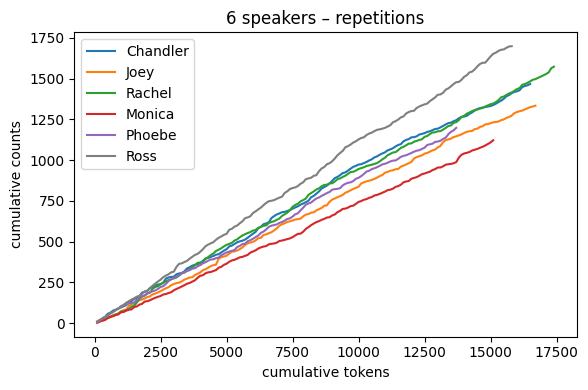

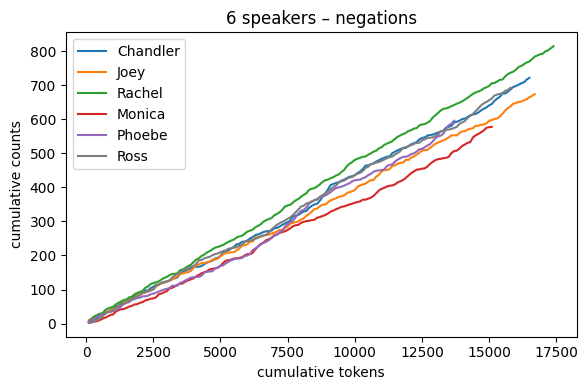

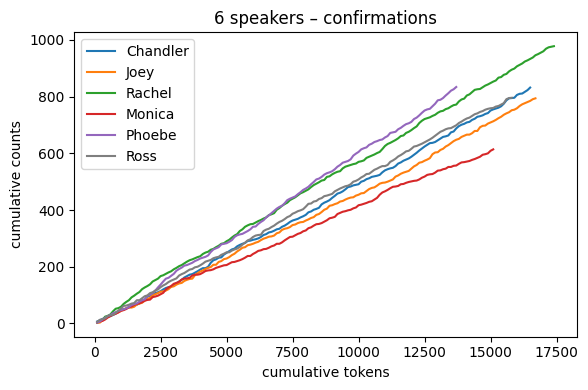

In [56]:
import matplotlib.pyplot as plt

colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#7f7f7f']

for feat, fname in zip(['repitition_count_arr', 'negation_count_arr', 'confirmation_count_arr'],
                       ['repetitions', 'negations', 'confirmations']):
    plt.figure(figsize=(6, 4))
    for speaker_name, c in zip(distinct_speakers1, colours):
        xs = utterance_features[speaker_name]['token_count_arr']
        ys = utterance_features[speaker_name][feat]
        plt.plot(xs, ys, color=c, label=speaker_name)

    plt.xlabel('cumulative tokens')
    plt.ylabel('cumulative counts')
    plt.title(f'6 speakers – {fname}')
    plt.legend()
    plt.tight_layout()
    plt.show()

Calculate the overall personality for each speaker by 
averaging over all instances of the original dataset,
and comment on possible similarities and differences between speakers
and whether some attributes are more associated with some personality patterns.

In [57]:
import numpy as np
import ast
for speaker_name in distinct_speakers1:
    # read original file and find speaker 1 as cuurent speaker, get their personality columns and average at last
    # traverse df to find rows where speaker 1 is the current speaker
    speaker_df = df.loc[df['Speaker_1']==speaker_name]
    # get Personality   column, which is an array for big 5 traits [1,2,0.4,0.6,0.9]
    personality = speaker_df['Personality'].values
    personality_arrays = np.array(
        speaker_df['Personality'].apply(ast.literal_eval).tolist()
    )
    print(f"{speaker_name} personality traits: {personality[0]}")    
    avg = np.mean(personality_arrays, axis=0)
    print(f"{speaker_name} average personality traits: {avg}")

Chandler personality traits: [0.648, 0.375, 0.386, 0.58, 0.477]
Chandler average personality traits: [0.648 0.375 0.386 0.58  0.477]
Joey personality traits: [0.574, 0.614, 0.297, 0.545, 0.455]
Joey average personality traits: [0.574 0.614 0.297 0.545 0.455]
Rachel personality traits: [0.635, 0.354, 0.521, 0.552, 0.469]
Rachel average personality traits: [0.635 0.354 0.521 0.552 0.469]
Monica personality traits: [0.713, 0.457, 0.457, 0.66, 0.511]
Monica average personality traits: [0.713 0.457 0.457 0.66  0.511]
Phoebe personality traits: [0.6, 0.48, 0.31, 0.46, 0.56]
Phoebe average personality traits: [0.6  0.48 0.31 0.46 0.56]
Ross personality traits: [0.722, 0.489, 0.6, 0.533, 0.356]
Ross average personality traits: [0.722 0.489 0.6   0.533 0.356]


### 2
We want to evaluate the extent to which a speaker changes topic during conversation

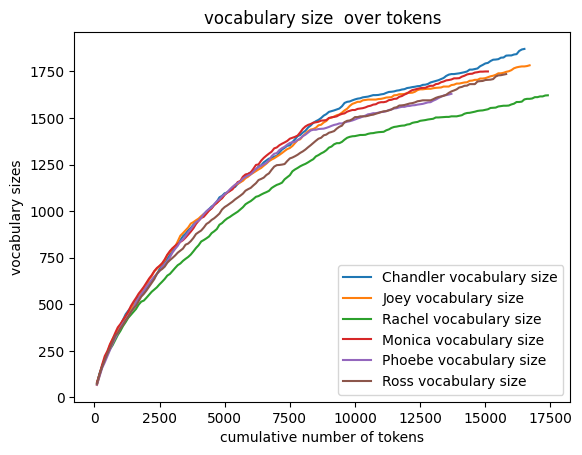

In [58]:
# plots the evolution of the vocabulary size with respect to the number of tokens employed 
   
import matplotlib.pyplot as plt

for speaker_name in distinct_speakers1:
    xs   = utterance_features[speaker_name]['token_count_arr']
    vocs = utterance_features[speaker_name]['vocab_count_arr']
    plt.plot(xs, vocs, label= speaker_name + ' vocabulary size')
plt.xlabel('cumulative number of tokens')  
plt.ylabel('vocabulary sizes')
plt.title('vocabulary size  over tokens')
plt.legend()                            
plt.show() 




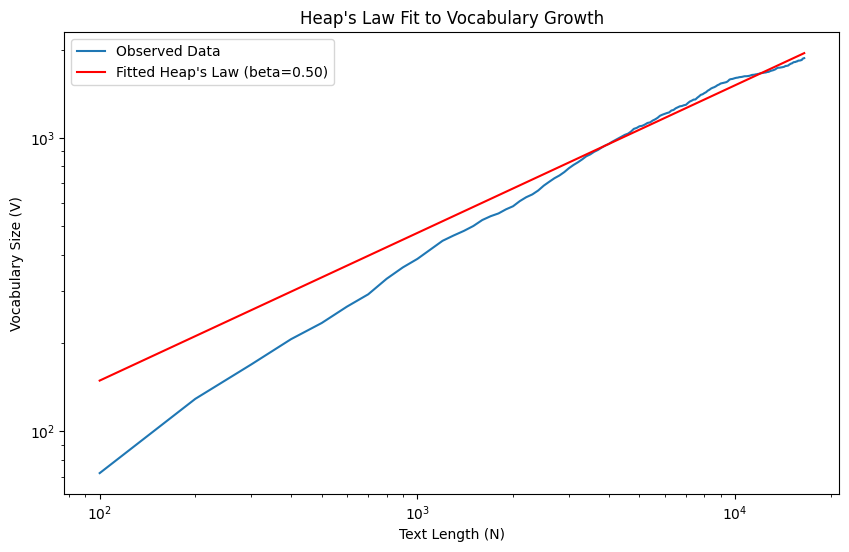

In [59]:

# Use log-log to fit heaps' law - chandler only
def heaps_law(N, K, beta):
    return K * N**beta
from scipy.optimize import curve_fit
popt, pcov = curve_fit(heaps_law, utterance_features['Chandler']['token_count_arr'], utterance_features['Chandler']['vocab_count_arr'], p0=[100, 0.5], maxfev=5000)
K_est, beta_est = popt
# Plot results
plt.figure(figsize=(10, 6))
plt.loglog(utterance_features['Chandler']['token_count_arr'], utterance_features['Chandler']['vocab_count_arr'], label='Observed Data')
plt.loglog(utterance_features['Chandler']['token_count_arr'], heaps_law(utterance_features['Chandler']['token_count_arr'], K_est, beta_est), linestyle='-', color='red', label=f'Fitted Heap\'s Law (beta={beta_est:.2f})')
plt.xlabel('Text Length (N)')
plt.ylabel('Vocabulary Size (V)')
plt.title('Heap\'s Law Fit to Vocabulary Growth')
plt.legend()
plt.show()

determine the topic number use  (need reference paper)
- Use coherence score
- Use perlexity score

In [60]:
# remove stop words (contribute noting to topic modeling)
# lemmatization
#  try different topic numbers and evaluate coherence and perlexity scores
# choose the topic number that give high coherence and low perlexity

In [61]:

# Read each main character's utterances from CSV files
import pandas as pd
df_Chandler = pd.read_csv('Chandler_utterances.csv')
df_Monica = pd.read_csv('Monica_utterances.csv')
df_Ross = pd.read_csv('Ross_utterances.csv')
df_Rachel = pd.read_csv('Rachel_utterances.csv')
df_Joey = pd.read_csv('Joey_utterances.csv')
df_Phoebe = pd.read_csv('Phoebe_utterances.csv')

# remove stop words and lemmatization
# remove filler words, filter out names, min word length is 4
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
stop_words = set(stopwords.words('english'))
# Are spoken words useful for topic modeling?
character_names = ['ross', 'rachel', 'monica', 'joey', 'chandler', 'phoebe', 
                    'rach', 'mon', 'pheebs', 'carol', 'emily', 'janice', 'ben',
                    'mike', 'david', 'richard', 'paolo', 'barry', 'susan']

# Extended filler words list
filler_words = ['oh', 'uh', 'um', 'umm', 'ah', 'eh', 'well', 'okay', 'ok', 
                'hey', 'hi', 'hello', 'bye', 'yeah', 'yes', 'no', 'nah',
                'like', 'just', 'really', 'actually', 'basically', 'literally',
                'anyway', 'anyways', 'whatever', 'nevermind', 'alright',
                'gonna', 'wanna', 'gotta', 'lemme', 'cause', 'cuz']


tokenizer = RegexpTokenizer(r"[A-Za-z']+")
lemmatizer = WordNetLemmatizer()
def preprocess_texts(df, filter_tokens=True):
    utterances = df['utterance'].str.lower().tolist()
    processed_texts = []
    for sentence in utterances:
        tokens = tokenizer.tokenize(sentence)
        filtered_tokens = tokens
        if filter_tokens:
            filtered_tokens = [lemmatizer.lemmatize(t) for t in tokens
                    if t not in stop_words and t.lower() not in filler_words and len(t) > 3 and t.lower() not in character_names]
        processed_texts.append(filtered_tokens)
    return processed_texts
text_chandler = preprocess_texts(df_Chandler)
text_monica   = preprocess_texts(df_Monica)
text_ross     = preprocess_texts(df_Ross)
text_rachel   = preprocess_texts(df_Rachel)
text_joey     = preprocess_texts(df_Joey)
text_phoebe   = preprocess_texts(df_Phoebe)

print(text_chandler)
print(len(text_chandler))
        
        

[['also', 'point', 'person', 'company', 'transition', 'system'], [], ['duty', 'right'], [], ['good', 'know'], [], [], ['ever'], [], ['coffee', 'hang'], ['beer'], ['betcha'], ['good', 'done', 'notch'], [], ['whole', 'thing'], ['love', 'specific', 'specific', 'best', 'part'], ['enough', 'honey'], ['great'], ['hold', 'moment', 'another', 'call', 'love'], ['back'], ['absolutely', "'bout", 'tomorrow', 'afternoon', 'know', 'central', 'perk', 'village', 'five'], ['phone', 'finally', 'paid'], ['hoping', 'show', 'seek', 'comfort', 'open', 'arm', 'stranger', 'next', 'table'], [], ['great', 'toilet', 'right'], ['sound', 'hernia', 'doctor'], ['want', 'hint'], ['right', 'pocket'], ['thanks'], ['right', 'ridiculous', 'name'], ['ticket', 'please', 'courtside', 'baby'], ['seriously', 'want'], [], [], ['dana', 'keystone', 'college'], ["victoria's", 'secret', 'model', 'something', 'something', 'goodacre'], ['right', 'jill', 'jill', 'goodacre', 'trapped', 'vestibule', 'jill', 'goodacre'], ['jill', 'say',

In [103]:
from gensim import corpora, models

def train_model_with_different_topic_numbers(speaker_name, texts, k_range):
    dictionary = corpora.Dictionary(texts)
    corpus     = [dictionary.doc2bow(t) for t in texts]

    split = int(0.8 * len(corpus))
    train_corpus, test_corpus = corpus[:split], corpus[split:]
    train_texts,  test_texts  = texts[:split],  texts[split:]

    c_scores, p_scores_test, ldas = [], [], []

    for k in k_range:
        lda = models.LdaModel(train_corpus, id2word=dictionary, num_topics=k,
                    passes=10, random_state=42)
        
        # Coherence (using training data)
        cm = models.CoherenceModel(model=lda, corpus=train_corpus, texts=train_texts,
                            coherence='c_v')
        c_scores.append((k, cm.get_coherence()))
        
        # Perplexity on TEST data (for evaluation)
        p_scores_test.append((k, lda.log_perplexity(test_corpus)))
        
        # Perplexity on TRAIN data (to check overfitting)
        ldas.append(lda)
    
    return c_scores, p_scores_test, ldas
   
        
       

In [ ]:
k_range = range(1, 20)
user_scores = {}
for speaker_name in distinct_speakers1:
    user_scores[speaker_name] = train_model_with_different_topic_numbers(
        speaker_name,
        globals()[f'text_{speaker_name.lower()}'],
        k_range
    )



In [ ]:
print(user_scores['Chandler'])

([(1, 0.48318882017337544), (2, 0.509512646778512)], [(1, -7.795477142804451), (2, -8.663077261661265)], [<gensim.models.ldamodel.LdaModel object at 0x0000019E025DB110>, <gensim.models.ldamodel.LdaModel object at 0x0000019E015EEE50>])


Chandler best weighted score=0.7000 at K=2


C:\Users\cxiru\AppData\Local\Temp\ipykernel_23732\3564062412.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right', bbox_to_anchor=(0.98, 0.85))


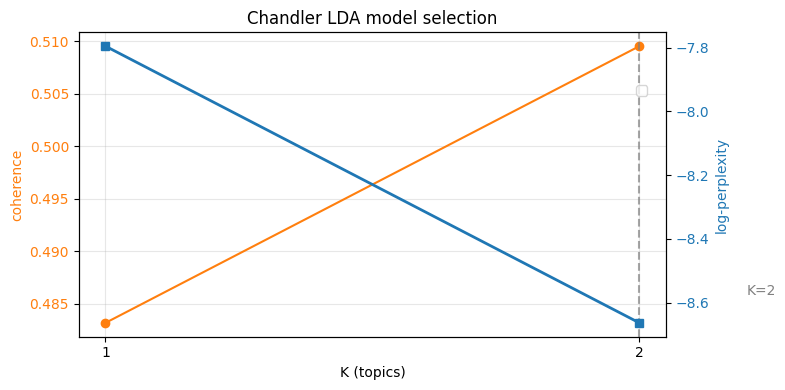


Chandler - Best K: 2
Joey best weighted score=0.7000 at K=2


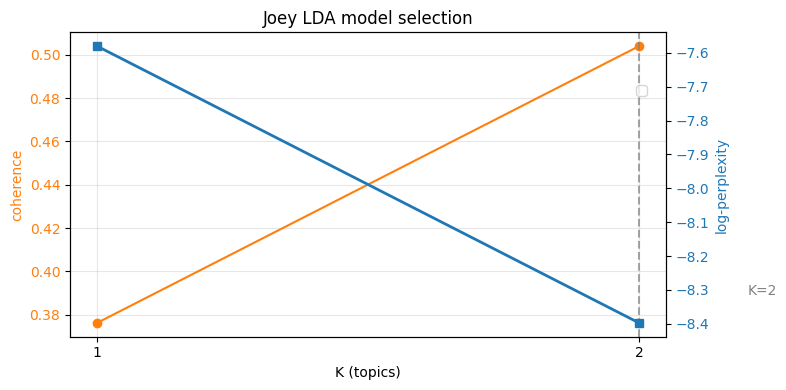


Joey - Best K: 2
Rachel best weighted score=1.0000 at K=1


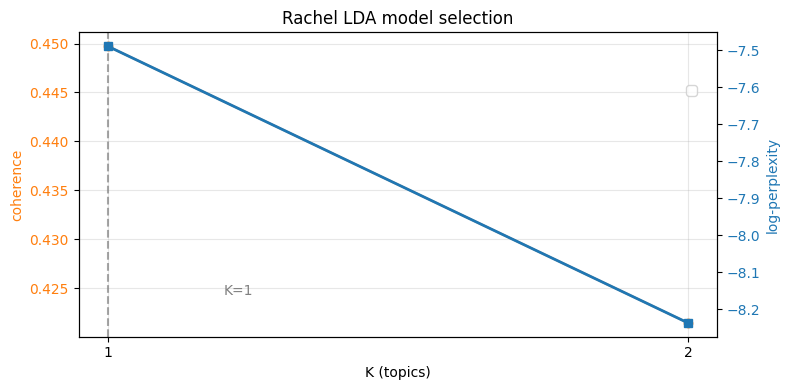


Rachel - Best K: 1
Monica best weighted score=0.7000 at K=2


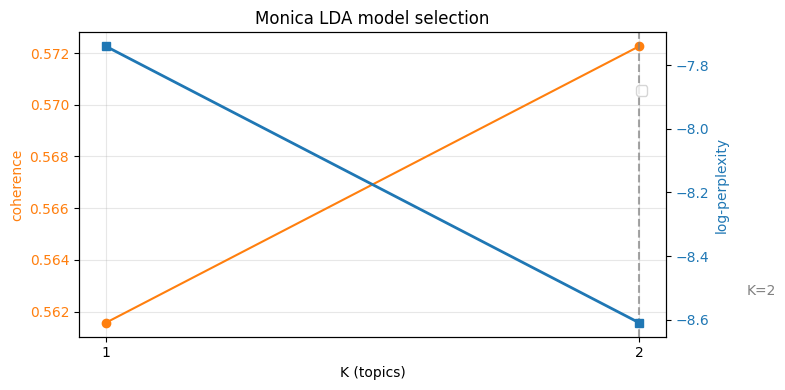


Monica - Best K: 2
Phoebe best weighted score=0.7000 at K=2


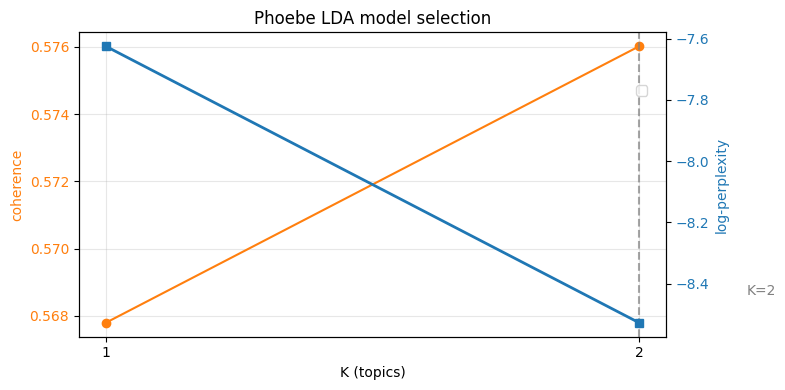


Phoebe - Best K: 2
Ross best weighted score=0.7000 at K=2


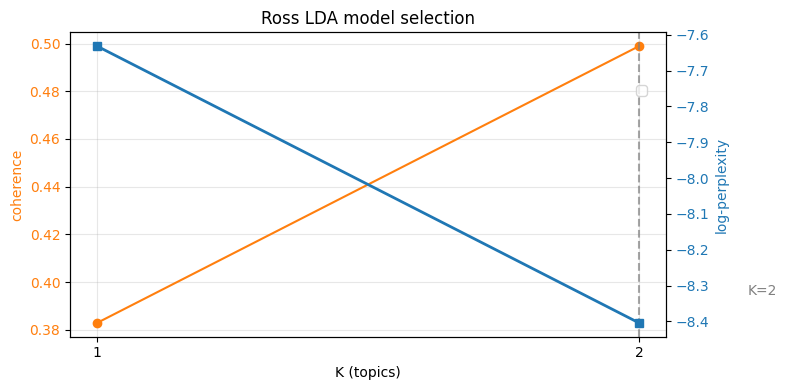


Ross - Best K: 2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import min, max 

def norm(x, high_good=True):
    return (x - x.min()) / (x.ptp()) if high_good else (x.max() - x) / x.ptp()

best_ks = {}
best_scores = {}

for speaker_name in distinct_speakers1:
    c_scores, p_scores_test, ldas = user_scores[speaker_name]
    K, coh, perp_test = map(np.array, zip(*[(k, c, p) for (k, c), (_, p) in zip(c_scores, p_scores_test)]))

    
    # search reference for this line (how to find best k, why normalize)
    alpha = 0.3  # weight for perplexity
    beta = 0.7   # weight for coherence (higher, since we want interpretable topics)
    best_k = K[(beta * norm(coh) + alpha * (1 - norm(perp_test, high_good=False))).argmax()]
    score = beta * norm(coh) + alpha * (1 - norm(perp_test, high_good=False))
    best_score = float(np.nanmax(score))
    print(f"{speaker_name} best weighted score={best_score:.4f} at K={best_k}")
    best_scores[speaker_name] = best_score
    best_ks[speaker_name] = best_k
    topic_number, coherence_score = zip(*c_scores)
    coherence_score = np.array(coherence_score)
    topic_number_2, perplexity_score_test = zip(*p_scores_test)

    fig, ax1 = plt.subplots(figsize=(8, 4))  # Made wider for better visibility

    # --- coherence axis (left) ---
    ax1.set_xticks(topic_number)
    ax1.plot(topic_number, coherence_score, 'o-', color='tab:orange', label='coherence')
    ax1.set_ylabel('coherence', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_xlabel('K (topics)')
    ax1.grid(alpha=.3)

    # --- perplexity axis (right) ---
    ax2 = ax1.twinx()
    # Plot test perplexity
    ax2.plot(topic_number_2, perplexity_score_test, 's-', color='tab:blue', 
              linewidth=2)
    ax2.set_ylabel('log-perplexity', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # --- annotate best K ---
    ax1.axvline(best_k, color='grey', ls='--', alpha=.7)
    
    # Adjust text position to avoid overlap
    y_pos = min(coherence_score) + (max(coherence_score) - min(coherence_score)) * 0.1
    ax1.text(best_k + 0.2, y_pos, f'K={best_k}', color='grey', fontsize=10)

    # --- Add legend for perplexity lines ---
    ax2.legend(loc='upper right', bbox_to_anchor=(0.98, 0.85))


    plt.title(f'{speaker_name} LDA model selection')
    plt.tight_layout()
    plt.show()

    print(f"\n{speaker_name} - Best K: {best_k}")

In [ ]:
# List of topics for each character with the best K

best_topics = {}
for speaker_name in distinct_speakers1:
    best_k = best_ks[speaker_name]
    coherence_score = user_scores[speaker_name][0][best_k - 1][1]
    perplexity_score = user_scores[speaker_name][1][best_k - 1][1]
    best_weighed_score = best_scores[speaker_name]
    print(f"{speaker_name} best topic number={best_k} coherence={coherence_score:.2f} perplexity={perplexity_score:.2f} best weighted_score={best_weighed_score:.2f}")
    best_topics[speaker_name] = [f"Topic {i}" for i in range(best_k)]

Chandler best topic number=2 coherence=0.51 perplexity=-8.66 best weighted_score=0.70
Joey best topic number=2 coherence=0.50 perplexity=-8.40 best weighted_score=0.70
Rachel best topic number=1 coherence=0.45 perplexity=-7.49 best weighted_score=1.00
Monica best topic number=2 coherence=0.57 perplexity=-8.61 best weighted_score=0.70
Phoebe best topic number=2 coherence=0.58 perplexity=-8.53 best weighted_score=0.70
Ross best topic number=2 coherence=0.50 perplexity=-8.40 best weighted_score=0.70


In [ ]:
final_lda_models = {}


In [ ]:
# print topic list for each character
for speaker_name in distinct_speakers1:
    lda = user_scores[speaker_name][2][best_ks[speaker_name]-1]
    for t_id in range(lda.num_topics):
        topn = [f'{w} ({p:.3f})' for w, p in lda.show_topic(t_id, topn=5)]
        rows.append([f'Topic {t_id+1}'] + topn)
    print(tabulate(rows, headers=['Topic'] + [f'Word {i+1}' for i in range(10)]))

KeyError: 'Chandler'

In [ ]:
from empath import Empath
from builtins import max
from operator import itemgetter
emp = Empath()

def empath_label(topic_words_with_probs):
    topic_concat = ' '.join([w for w, _ in topic_words_with_probs])
    scores = emp.analyze(topic_concat, normalize=True)
    non_zero = {cat: v for cat, v in scores.items() if v > 0}
    if non_zero:
        best_cat, best_val = max(non_zero.items(), key=itemgetter(1))
        return best_cat, best_val
    return None, 0.0


topn_count = 10
for speaker_name in distinct_speakers1:
    lda = final_lda_models[speaker_name]
    ranking = []                        # <<-- fresh list per speaker
    for t_id in range(lda.num_topics):
        top_n = lda.show_topic(t_id, topn_count)
        cat, val = empath_label(top_n)
        if val:                         # skip empties
            ranking.append((val, cat, t_id+1))

    # sort this speaker only
    ranking.sort(reverse=True, key=itemgetter(0))

    print(f'\n{speaker_name}  (Topic count = {lda.num_topics})')
    for val, cat, tid in ranking:
        print(f'  {val:.2f}  {cat:<18}  Topic {tid}')


Chandler  (Topic count = 10)
  0.30  negative_emotion    Topic 2
  0.30  friends             Topic 4
  0.20  negative_emotion    Topic 5
  0.10  communication       Topic 1
  0.10  ridicule            Topic 3
  0.10  college             Topic 6
  0.10  business            Topic 7
  0.10  leisure             Topic 8
  0.10  sleep               Topic 10

Joey  (Topic count = 7)
  0.30  positive_emotion    Topic 4
  0.20  giving              Topic 5
  0.20  music               Topic 7
  0.10  family              Topic 1
  0.10  violence            Topic 2
  0.10  attractive          Topic 3
  0.10  movement            Topic 6

Rachel  (Topic count = 13)
  0.20  communication       Topic 1
  0.20  morning             Topic 6
  0.20  communication       Topic 7
  0.20  body                Topic 10
  0.20  wedding             Topic 12
  0.10  sleep               Topic 2
  0.10  school              Topic 3
  0.10  attractive          Topic 4
  0.10  communication       Topic 5
  0.10  attrac

### 3.
We want to test whether some emotion patterns are occurring with some particular personality trait

In [ ]:
import pandas as pd
# Download VAD lexicon from GitHub repository
url = "https://raw.githubusercontent.com/Priya22/EmotionDynamics/master/lexicons/NRC_EmoLex_NRC-VAD-Lexicon.txt"
vad = pd.read_csv(url, sep='\t', names=['word','valence','arousal','dominance'])
vad = vad.set_index('word')
vad.to_csv('NRC-VAD.csv', index=False)   # now you have NRC-VAD.csv


In [ ]:
text_chandler = preprocess_texts(df_Chandler, False)
text_monica   = preprocess_texts(df_Monica, False)
text_ross     = preprocess_texts(df_Ross, False)
text_rachel   = preprocess_texts(df_Rachel, False)
text_joey     = preprocess_texts(df_Joey, False)
text_phoebe   = preprocess_texts(df_Phoebe, False)

In [ ]:
# flatten every character's list-of-lists in one shot with lower case
flat_speaker_tokens = {}
for name in distinct_speakers1:
    src = globals()[f'text_{name.lower()}']  
    flat_speaker_tokens[name] = [tok.lower() for utt in src for tok in utt]

print(flat_speaker_tokens)

{'Chandler': ['also', 'i', 'was', 'the', 'point', 'person', 'on', 'my', 'company', 's', 'transition', 'from', 'the', 'kl', 'to', 'gr', 'system', 'that', 'i', 'did', 'that', 'i', 'did', 'my', 'duties', 'all', 'right', 'i', 'see', 'good', 'to', 'know', 'no', 'don', 't', 'i', 'beg', 'of', 'you', 'hey', 'mon', 'do', 'i', 'ever', 'no', 'way', 'just', 'coffee', 'where', 'are', 'we', 'gonna', 'hang', 'out', 'now', 'can', 'i', 'get', 'a', 'beer', 'you', 'betcha', 'good', 'job', 'joe', 'well', 'done', 'top', 'notch', 'oh', 'ho', 'ho', 'yeah', 'the', 'whole', 'thing', 'can', 'we', 'go', 'i', 'love', 'the', 'specifics', 'the', 'specifics', 'were', 'the', 'best', 'part', 'okay', 'that', 's', 'enough', 'honey', 'great', 'okay', 'here', 'can', 'you', 'hold', 'on', 'a', 'moment', 'i', 'have', 'another', 'call', 'i', 'love', 'her', "i'm", 'back', 'um', 'absolutely', 'uh', 'how', "'bout", 'tomorrow', 'afternoon', 'do', 'you', 'know', 'uh', 'central', 'perk', 'in', 'the', 'village', 'say', 'five', 'ish'

In [ ]:
def vad_statistics(tokens):
    """return mean (valence, arousal, dominance) for a list of token"""
    hits = vad.reindex(tokens).dropna()
    if hits.empty:
        return np.nan, np.nan, np.nan
    mean = (hits.valence.mean(), hits.arousal.mean(), hits.dominance.mean())
    sd = (hits.valence.std(ddof=1), hits.arousal.std(ddof=1), hits.dominance.std(ddof=1))
    min = (hits.valence.min(), hits.arousal.min(), hits.dominance.min())
    max = (hits.valence.max(), hits.arousal.max(), hits.dominance.max())
    return mean, sd, min, max

In [ ]:

# display VAD statistics for each character
rows = []
for name in distinct_speakers1:
    mean_vad, sd_vad, min_vad, max_vad = vad_statistics(flat_speaker_tokens[name])
    rows.append([name,
                 tuple(round(x, 3) for x in mean_vad),
                 tuple(round(x, 3) for x in sd_vad),
                 tuple(round(x, 3) for x in min_vad),
                 tuple(round(x, 3) for x in max_vad)])

df_vad = pd.DataFrame(rows, columns=["Speaker", "VAD-mean", "VAD-sd", "VAD-min", "VAD-max"])
print(tabulate(rows,
               headers=["Speaker", "VAD-mean", "VAD-sd", "VAD-min", "VAD-max"],
               tablefmt="simple"))

Speaker    VAD-mean               VAD-sd                 VAD-min                VAD-max
---------  ---------------------  ---------------------  ---------------------  -------------------
Chandler   (0.624, 0.439, 0.518)  (0.2, 0.161, 0.162)    (0.01, 0.071, 0.081)   (1.0, 0.945, 0.973)
Joey       (0.632, 0.428, 0.516)  (0.187, 0.154, 0.158)  (0.02, 0.073, 0.12)    (1.0, 0.945, 0.972)
Rachel     (0.633, 0.437, 0.524)  (0.201, 0.157, 0.164)  (0.02, 0.082, 0.113)   (1.0, 0.952, 0.981)
Monica     (0.623, 0.435, 0.507)  (0.201, 0.161, 0.165)  (0.01, 0.046, 0.081)   (1.0, 0.959, 0.981)
Phoebe     (0.624, 0.431, 0.508)  (0.204, 0.159, 0.163)  (0.01, 0.09, 0.087)    (1.0, 0.971, 0.972)
Ross       (0.634, 0.434, 0.522)  (0.194, 0.161, 0.158)  (0.005, 0.073, 0.081)  (1.0, 0.959, 0.963)


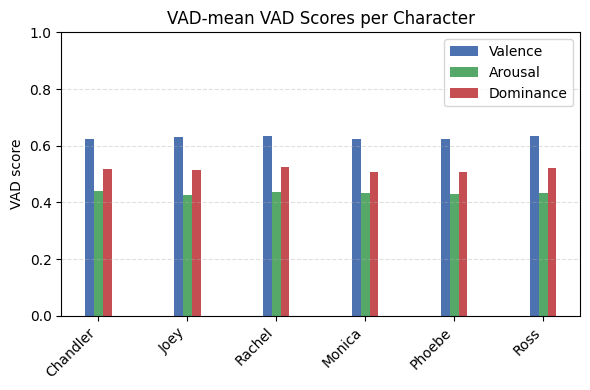

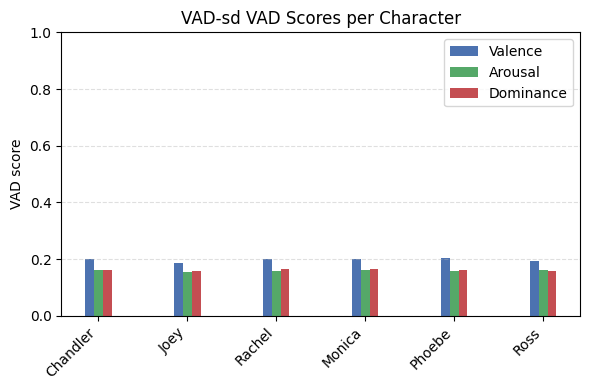

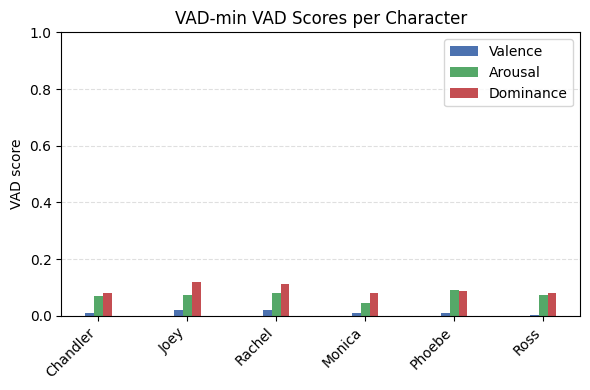

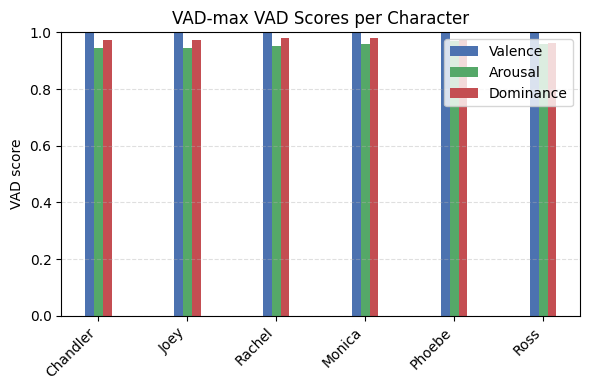

In [ ]:
def plot_vad():
    """Plot average, standard deviation, min, max VAD scores per character as grouped bar chart"""
    names = df_vad["Speaker"].values
    statistic_names = ["VAD-mean", "VAD-sd", "VAD-min", "VAD-max"]
    for stat_name in statistic_names:
        v = df_vad[stat_name].apply(lambda t: t[0]).values
        a = df_vad[stat_name].apply(lambda t: t[1]).values
        d = df_vad[stat_name].apply(lambda t: t[2]).values
        x = np.arange(len(names))          # one group per character
        width = 0.1                       # width of a single bar

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.bar(x - width,  v, width, label='Valence',  color='#4c72b0')
        ax.bar(x,          a, width, label='Arousal',  color='#55a868')
        ax.bar(x + width,  d, width, label='Dominance',color='#c44e52')
        ax.set_ylabel('VAD score')
        ax.set_title(f'{stat_name} VAD Scores per Character')
        ax.set_xticks(x)
        ax.set_xticklabels(names, rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(axis='y', ls='--', alpha=0.4)
        fig.tight_layout()
        plt.show()
        

plot_vad()

C:\Users\cxiru\AppData\Local\Temp\ipykernel_23732\2749633425.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=long_df, x='score', y='speaker', kind='box',


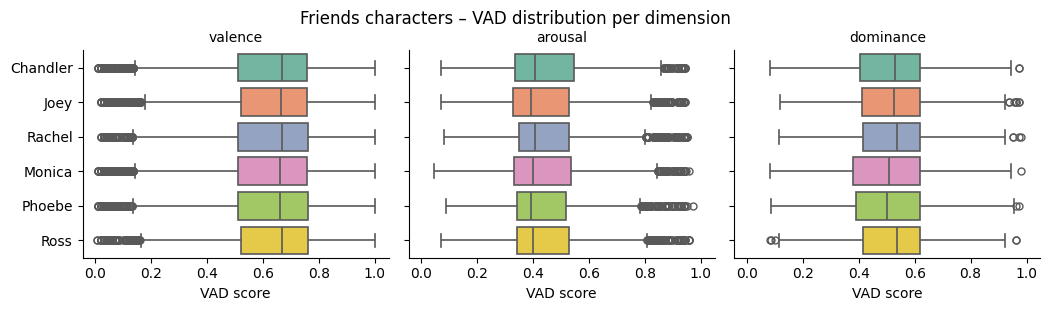

In [ ]:
# plot box chart to assist analysis of VAD distribution per character - not required in the report material
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd, numpy as np

# 1.  long-form dataframe: one row per token
long_df = []
for name in distinct_speakers1:
    toks = flat_speaker_tokens[name]
    hits = vad.reindex(toks).dropna()
    for _, row in hits.iterrows():
        long_df.append({'speaker': name, 'dim': 'valence',  'score': row.valence})
        long_df.append({'speaker': name, 'dim': 'arousal',  'score': row.arousal})
        long_df.append({'speaker': name, 'dim': 'dominance','score': row.dominance})
long_df = pd.DataFrame(long_df)

# 2.  three horizontal box-plots
g = sns.catplot(data=long_df, x='score', y='speaker', kind='box',
                col='dim', col_wrap=3, height=3, aspect=1.2,
                palette='Set2', linewidth=1.2)
g.set_axis_labels("VAD score", "")
g.set_titles("{col_name}")
g.fig.suptitle("Friends characters – VAD distribution per dimension", y=1.02)
plt.show()

### 4.
instead of considering overall speaker’s utterances, we want to investigate individual personality trait cases. 

In [ ]:
import pandas as pd
# reports the dominant personality trait from the scores of the five personality traits, OCEAN

df = pd.read_csv("Dyadic_PELD.tsv", sep="\t")
trait_names = ["O", "C", "E", "A", "N"]

def dominant_trait(personality_str):
    big_5_scores = [float(x) for x in personality_str.strip('[]').split(',')]
    max_score_idx = pd.Series(big_5_scores).idxmax()
    return trait_names[max_score_idx], big_5_scores[max_score_idx]

df[["dominant_trait", "dominant_score"]] = (
    df["Personality"].apply(lambda p: pd.Series(dominant_trait(p)))
)

print("Dominant-trait counts for Speaker_1:")
print(df["dominant_trait"].value_counts())

df.to_csv("Dyadic_PELD_with_dominant.tsv", sep="\t", index=False)

Dominant-trait counts for Speaker_1:
dominant_trait
O    5387
C    1123
Name: count, dtype: int64


In [ ]:
# Construct a new dataframe for each personality trait by gathering all utterances that fall on this category  O/C/E/A/N

trait_dfs = {}
for trait in trait_names:
    utts = (df.loc[df['dominant_trait'].eq(trait), 'Utterance_1']
              .dropna()
              .drop_duplicates()
              .reset_index(drop=True)
              .rename('utterance'))
    trait_dfs[trait] = pd.DataFrame({'trait': trait, 'utterance': utts})
    
print(trait_dfs['O'].head())

  trait                                          utterance
0     O  also I was the point person on my company s tr...
1     O                            That I did. That I did.
2     O                             My duties?  All right.
3     O                                             I see.
4     O                                      Good to know.


In [ ]:
stride = 10
# from previous step we know only O and C are dominant traits for speakers
trait_names = ["O", "C"]
trait_statistics = {}
for trait in trait_names:
    trait_statistics[trait] = build_speaker_vocab_info(trait_dfs[trait], stride)
# Prepare data for tabulate
table_data = []
headers = ["Character", "Tokens", "Vocabulary", "Total Repetitions", "Confirmation Words", "Negation Words"]

for trait in trait_statistics:
    row = [
        trait,
        f"{len(trait_statistics[trait]['tokens']):,}",
        f"{len(trait_statistics[trait]['vocab']):,}",
        f"{trait_statistics[trait]['totalWordRep']:,}",
        f"{len(trait_statistics[trait]['confirmation_words']):,}",
        f"{trait_statistics[trait]['negation_tokens_count']:,}"
    ]
    table_data.append(row)

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+-------------+----------+--------------+---------------------+----------------------+------------------+
| Character   | Tokens   | Vocabulary   | Total Repetitions   | Confirmation Words   | Negation Words   |
+=============+==========+==============+=====================+======================+==================+
| O           | 43,545   | 3,876        | 4,229               | 2,170                | 1,853            |
+-------------+----------+--------------+---------------------+----------------------+------------------+
| C           | 9,669    | 1,585        | 832                 | 420                  | 377              |
+-------------+----------+--------------+---------------------+----------------------+------------------+


dict_keys(['O', 'C'])


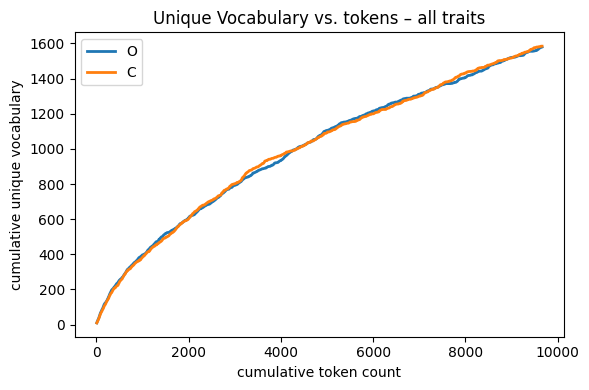

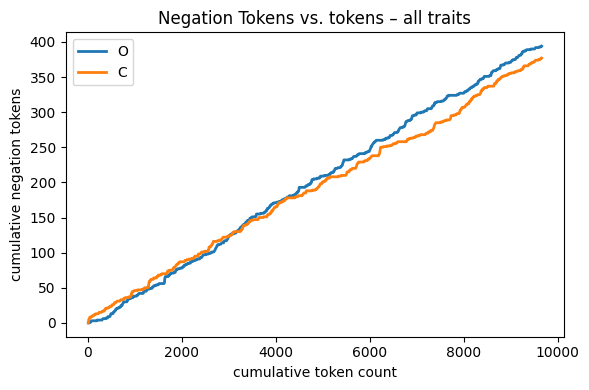

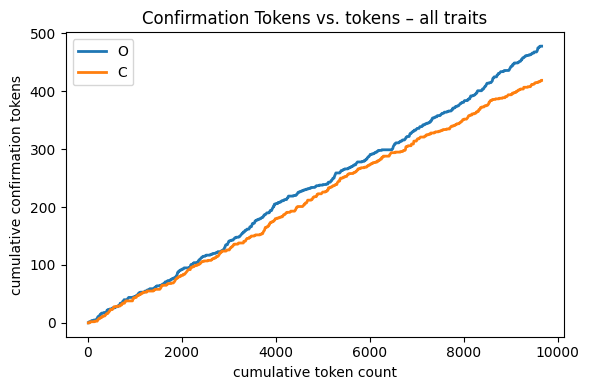

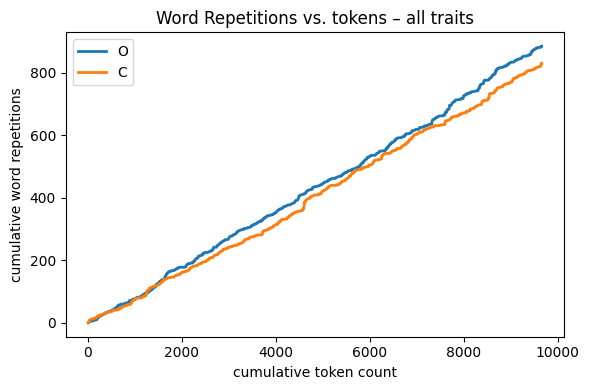

In [ ]:
# Plotting vocabulary features over utterances for each trait
import matplotlib.pyplot as plt

import builtins
len, range, min = builtins.len, builtins.range, builtins.min
traits = trait_statistics.keys()  
print(traits)
colors = plt.cm.tab10(range(len(traits))) # one colour per trait
# make x axis horizon equal to shortest series
min_len = min(len(trait_statistics[tr]['token_count_arr']) for tr in traits)


for feature, ylabel in [('vocab_count_arr', 'unique vocabulary'),
                        ('negation_count_arr', 'negation tokens'),
                        ('confirmation_count_arr', 'confirmation tokens'),
                        ('repitition_count_arr', 'word repetitions')]:

    plt.figure(figsize=(6, 4))
    for trait, col in zip(traits, colors):
        xs = trait_statistics[trait]['token_count_arr'][:min_len]
        ys = trait_statistics[trait][feature][:min_len]
        plt.plot(xs, ys, label=trait, color=col, linewidth=2)

    plt.xlabel('cumulative token count')
    plt.ylabel(f'cumulative {ylabel}')
    plt.title(f'{ylabel.title()} vs. tokens – all traits')
    plt.legend()
    plt.tight_layout()
    plt.show()                           

### 5.
 consider the definitions of each personality trait given in the figure below, use doc2vec embedding, DistilBERT embedding,
 uses the cosine similarity to evaluate the similarity between the dataframe and personality definition.

In [ ]:
import torch
from sklearn.metrics.pairwise import cosine_similarity


traits = {
    'Extraversion': {
        'pos': ['Talkative', 'Sociable', 'Adventurous', 'Open'],
        'neg': ['Silent', 'Reclusive', 'Cautious', 'Secretive']
    },
    'Agreeableness': {
        'pos': ['Good-natured', 'Cooperative', 'Mild/gentle', 'Not jealous'],
        'neg': ['Irritable', 'Negativistic', 'Headstrong', 'Jealous']
    },
    'Conscientiousness': {
        'pos': ['Responsible', 'Scrupulous', 'Persevering', 'Fussy/tidy'],
        'neg': ['Undependable', 'Unscrupulous', 'Quitting', 'Careless']
    },
    'Emotional': {
        'pos': ['Calm', 'Composed', 'Not hypochondriacal', 'Poised'],
        'neg': ['Anxious', 'Excitable', 'Hypochondriacal', 'Nervous/tense']
    },
    'Openness': {
        'pos': ['Intellectual', 'Artistic', 'Imaginative', 'Polished', 'Refined'],
        'neg': ['Unreflective', 'Narrow', 'Nonartistic', 'Simple', 'Direct', 'Crude', 'Boorish']
    }
}
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tok = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

device = 'cuda'
model = model.to(device)

def emb(texts):
    inputs = tok(texts, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        out = model(**inputs)
    return out.last_hidden_state.mean(1).cpu().numpy()   # back to RAM



c:\Users\cxiru\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
trait_emb = {t: {'pos': emb(traits[t]['pos']), 'neg': emb(traits[t]['neg'])} for t in traits}


In [ ]:
speaker_emb = {}
for speaker in distinct_speakers1:
    df = pd.read_csv(f'{speaker}_utterances.csv')
    utterance_embeddings = emb(df['utterance'].tolist())
    speaker_emb[speaker] = utterance_embeddings

In [ ]:
speaker_big_5_profiles_positive = {}
speaker_big_5_profiles_negative = {}
for speaker in distinct_speakers1:
    scores_pos = []                                                     
    scores_neg = []                                                     
    for vec in speaker_emb[speaker]:                               
        sc_pos = {t: cosine_similarity([vec], trait_emb[t]['pos']).max() for t in traits}
        sc_neg = {t: cosine_similarity([vec], trait_emb[t]['neg']).max() for t in traits}
        scores_pos.append(sc_pos)
        scores_neg.append(sc_neg)
    profile_pos = pd.DataFrame(scores_pos).mean()    
    profile_neg = pd.DataFrame(scores_neg).mean()    
    speaker_big_5_profiles_negative[speaker] = profile_neg                      
    speaker_big_5_profiles_positive[speaker] = profile_pos
    

In [ ]:
df_pos = pd.DataFrame(speaker_big_5_profiles_positive).T.loc[:, ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional']]
df_neg = pd.DataFrame(speaker_big_5_profiles_negative).T.loc[:, ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional']]
print("Big-5 personality profiles (positive trait words):")
df_pos.round(3)


Big-5 personality profiles (positive trait words):


,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional
Chandler,0.377,0.570,0.484,0.613,0.645
Joey,0.374,0.566,0.482,0.609,0.641
Rachel,0.359,0.555,0.471,0.601,0.647
Monica,0.375,0.569,0.484,0.611,0.650
Phoebe,0.370,0.565,0.481,0.608,0.653
Ross,0.364,0.561,0.475,0.607,0.648


In [ ]:
print("Big-5 personality profiles (negative trait words):")
df_neg.round(3)

Big-5 personality profiles (negative trait words):


,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional
Chandler,0.601,0.614,0.562,0.611,0.647
Joey,0.602,0.609,0.557,0.609,0.642
Rachel,0.593,0.609,0.553,0.602,0.648
Monica,0.602,0.617,0.564,0.614,0.651
Phoebe,0.601,0.617,0.563,0.610,0.653
Ross,0.595,0.611,0.558,0.604,0.649


In [ ]:
print("Signed Big-5 personality profiles (positive - negative trait words):")
signed = df_pos.sub(df_neg)       
signed.round(3)

Signed Big-5 personality profiles (positive - negative trait words):


,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional
Chandler,-0.225,-0.044,-0.078,0.002,-0.001
Joey,-0.229,-0.043,-0.076,-0.001,-0.001
Rachel,-0.234,-0.054,-0.082,-0.000,-0.001
Monica,-0.228,-0.049,-0.079,-0.003,-0.001
Phoebe,-0.232,-0.052,-0.081,-0.002,-0.000
Ross,-0.231,-0.050,-0.083,0.003,-0.002


What is z score? 
https://www.investopedia.com/terms/z/zscore.asp

A z-score is important because it tells where your data lies in the data distribution. For example, if a z-score is 1.5, it is 1.5 standard deviations away from the mean. Because 68% of your data lies within one standard deviation (if it is normally distributed), 1.5 might be considered too far from average for your comfort.

In [ ]:
print("Z-Score normalized Signed Big-5 personality profiles:")
z = signed.sub(signed.mean()).div(signed.std())
z.round(2)

Z-Score normalized Signed Big-5 personality profiles:


,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional
Chandler,1.51,1.00,0.62,0.95,-0.66
Joey,0.28,1.30,1.62,-0.22,0.21
Rachel,-1.27,-1.32,-0.70,-0.12,-0.60
Monica,0.61,-0.01,0.12,-1.23,0.90
Phoebe,-0.64,-0.68,-0.58,-0.77,1.36
Ross,-0.49,-0.30,-1.08,1.39,-1.22


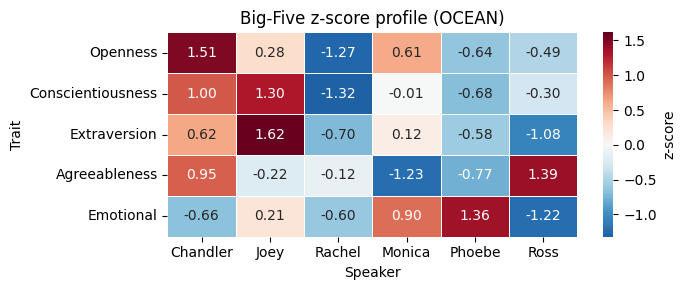

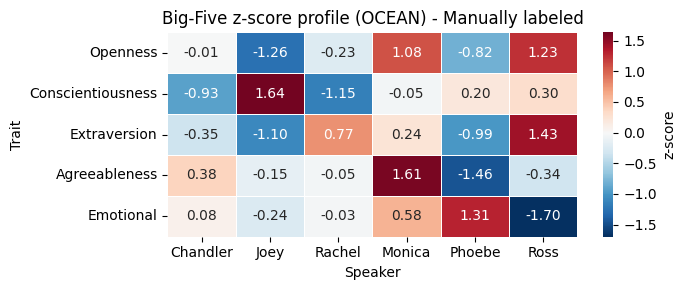

In [ ]:
import seaborn as sns
def plot_z_score_heatmap(z, title='Big-Five z-score profile (OCEAN)'):
    plt.figure(figsize=(7, 3))
    sns.heatmap(z.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                linewidths=.5, cbar_kws={'label': 'z-score'})
    plt.title(title)
    plt.xlabel('Speaker')
    plt.ylabel('Trait')
    plt.tight_layout()
    plt.show()
plot_z_score_heatmap(z)

original_score = {
    'Speaker': ['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross'],
    'Openness':     [0.648, 0.574, 0.713, 0.600, 0.635, 0.722],
    'Conscientiousness': [0.375, 0.614, 0.457, 0.480, 0.354, 0.489],
    'Extraversion': [0.386, 0.297, 0.457, 0.310, 0.521, 0.600],
    'Agreeableness': [0.580, 0.545, 0.660, 0.460, 0.552, 0.533],
    'Emotional':  [0.477, 0.455, 0.511, 0.560, 0.469, 0.356]
}

df_roles = pd.DataFrame(original_score).set_index('Speaker')

z_roles = df_roles.sub(df_roles.mean()).div(df_roles.std())

desired_order = ['Chandler', 'Joey', 'Rachel', 'Monica', 'Phoebe', 'Ross']
z_roles = z_roles.reindex(desired_order)
z_roles.round(2)
plot_z_score_heatmap(z_roles, 'Big-Five z-score profile (OCEAN) - Manually labeled')

### 6.
Build a ML model, for each given dialog utterances (A-B-A) and emotion label (negative/positive...)
, predict speakers A big 5 traits (e.g. [0,-1,1,1,0]) for each dialog

Regression like ML model

Input - tf-idf vector ( limit vocabulary)

Questions:
- For A-B-A dialog , should we input all of them , or only speaker A

In [ ]:
import ast
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


def build_model(df, use_senti_emotion=True, max_vocab=500, ngram=(1, 1)):
    # 1. merge utterances
    df = df.copy()
    df["Utterance"] = (df["Utterance_1"].astype(str).str.lower() + " " +
                       df["Utterance_3"].astype(str).str.lower())

    # 2. target
    pers = df["Personality"].apply(ast.literal_eval)
    y = pd.DataFrame(pers.tolist(), columns=["O", "C", "E", "A", "N"])

    # 3. transformers
    transformers = [
        ("txt", TfidfVectorizer(max_features=max_vocab,
                                ngram_range=ngram,
                                stop_words="english"), "Utterance"),
    ]
    if use_senti_emotion:
        transformers.append(
            ("cat", OneHotEncoder(handle_unknown="ignore"),
             ["Emotion_1", "Emotion_3", "Sentiment_1", "Sentiment_3"])
        )

    pre = ColumnTransformer(transformers=transformers, remainder="drop")
    model = Pipeline([("prep", pre), ("reg", Ridge(alpha=1.0))])

    # 4. build X
    X = df[["Utterance"] +
           (["Emotion_1", "Emotion_3", "Sentiment_1", "Sentiment_3"]
            if use_senti_emotion else [])]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    return model, X_train, X_test, y_train, y_test


def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    return r2, mse


if __name__ == "__main__":
    df = pd.read_csv("Dyadic_PELD.tsv", sep="\t"
                     )

    setups = [
        ("unigram-500-no-Senti", False, 500, (1, 1)),
        ("unigram-500-with-Senti", True, 500, (1, 1)),
        ("bigram-500-no-Senti",   False, 500, (1, 2)),
        ("unigram-5000-no-Senti", False, 5000, (1, 1))


    ]

    for name, senti, vocab, ng in setups:
        m, _, Xte, _, yte = build_model(df, senti, vocab, ng)
        r2, mse = evaluate(m, Xte, yte)
        print(f"{name:20s} | R²: {r2.round(3)} | MSE: {mse.round(4)}")

unigram-500-no-Senti | R²: [0.045 0.087 0.073 0.047 0.082] | MSE: [0.0028 0.0071 0.0114 0.0031 0.0034]
unigram-500-with-Senti | R²: [0.047 0.087 0.07  0.045 0.078] | MSE: [0.0028 0.0071 0.0114 0.0031 0.0034]
bigram-500-no-Senti  | R²: [0.043 0.071 0.053 0.045 0.071] | MSE: [0.0028 0.0072 0.0116 0.0031 0.0035]
unigram-5000-no-Senti | R²: [0.171 0.2   0.189 0.148 0.205] | MSE: [0.0025 0.0062 0.0099 0.0028 0.003 ]


Addition - not required:
We can also use this model, to predict big 5 score, and calculate cosine similaarity of the score and each speakers personality to find the best fit speaker, then validate through all the database how many speaker is predicted correctly according to the utterance & emotion